# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения 
    * SGD+momentum, Adam
    
Адрес для посылки ДЗ mfti_2018_hw03@mail.ru

In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Machine Learning/3')
# !cd /content/gdrive/Machine Learning/3

ModuleNotFoundError: No module named 'google'

In [0]:
!pwd

/content/gdrive/My Drive/Machine Learning/3


# Требуемые модули:
Python 3.6
1. pytorch=0.41 // [инструкция по установке](https://pytorch.org/get-started/previous-versions/)
2. torchvision=0.2.2.post3 // pip install ...
3. matplotlib  //
4. PIL=5.4.1
5. scipy=1.1.0
6. numpy=1.15.14
7. pickle

# Требования
1. Присылаем этот ноутбук только с полностью выполненными заданиями.
2. Файл должен называть MFTI_2019_hw03_ФАМИЛИЯ_ИМЯ.ipynb
3. Заданние должно быть выполнено до 24.03.2019 до 23:59.
4. После проверки у Вас будет одна попытка для исправления замечаний. 

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку <font collor='red'>__pytorch__</font>. Получаем на вход тензор размером $(C_{in}, H, W)$, на выходе получаем тензор $(C_{out}, H_{out}, W_{out})$.
$$
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки с параметрами:

$\large k $ - ядро свертки, тензор с парамерами $C_{in}, H_k, W_k,$ <br>
$stride_{H,W}$ - шаг ядра свертки, <br>
$padding_{H,W} $ - размер паддинга.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [9]:
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда, задаются в формате HxW
    :param  padding:  tuple - параметры паддинга, задаются в формате HxW
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    W = x.shape[2:]
    K = kernel.shape[1:]
    P = padding
    S = stride
    (h_out, w_out) = ((W[i] - K[i] + 2 * P[i]) / S[i] + 1 for i in range(2))

    h_out = int(h_out)
    w_out = int(w_out)

    output = torch.zeros(size=torch.Size((x.size()[0], h_out, w_out)))

    # handle padding
    new_size = torch.Size( map(lambda x, y: x + 2 * y, x.size(), [0, 0] + list(padding)) )
    x_padding = torch.zeros(size=new_size)

    x_padding[:, :, padding[0]: x.size()[2] + padding[0], padding[1]: x.size()[3] + padding[0]] = x
    x = x_padding

    for h in range(h_out):
        for w in range(w_out):
            h_in = h * stride[0]
            w_in = w * stride[1]
            chunk = x[:, :, h_in : h_in + kernel.size()[-2], w_in : w_in + kernel.size()[-1]]
            output[:, h, w] = torch.sum(kernel * chunk)
            pass

    if type(bias) is torch.Tensor:
        output = bias.cat(output)
    return output

In [10]:
# функции тестирования
from tests_functions import * 

### Загружаем картинку 

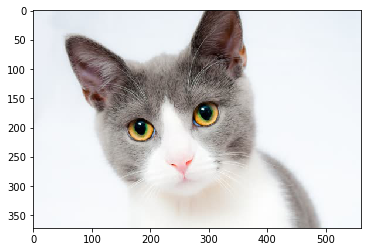

In [11]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [12]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
cat_tensor.unsqueeze_(0)
print (cat_tensor.size())

torch.Size([1, 3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [13]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

torch.Size([370, 558])


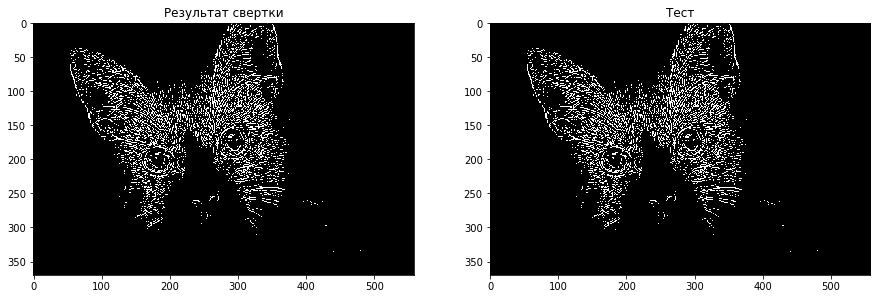

In [8]:
o_image = my_conv2d(cat_tensor, filter_kernel).squeeze_(0)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_01.pth')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [0]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])
max diff: 0.0


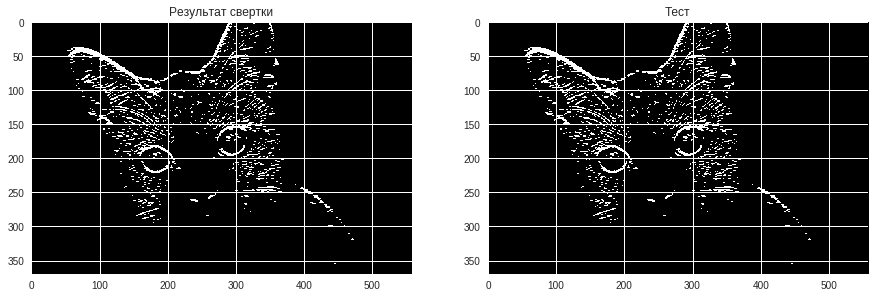

In [0]:
o_image = my_conv2d(cat_tensor, filter_kernel).squeeze_(0)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_02.pth')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [0]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])
max diff: 0.0


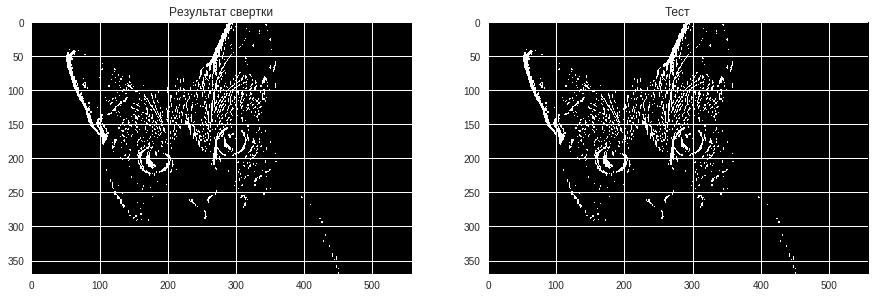

In [0]:
o_image = my_conv2d(cat_tensor, filter_kernel).squeeze_(0)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_03.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])
max diff: 0.0
torch.Size([186, 280])


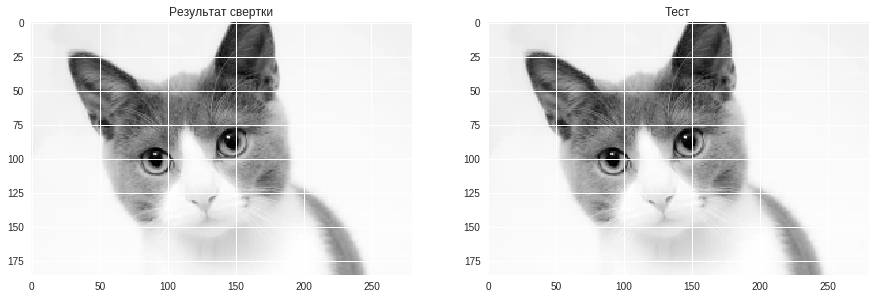

In [0]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2)).squeeze_(0)
o_image /= 4 # усредняем
torch.save(o_image, './data/kernel_05.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_05.pth')
assert o_image.size() == torch.Size([186, 280]), 'Размер выходного изображения не совпадает с размером теста'
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 1, padding 1

torch.Size([372, 560])
max diff: 0.0


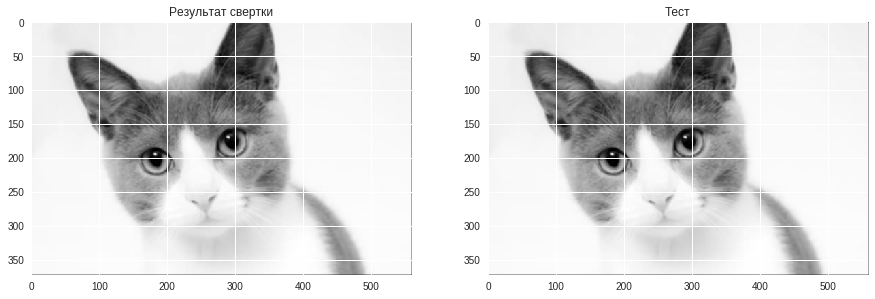

In [0]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(1,1), padding=(1,1)).squeeze_(0)
o_image /= 4 # усредняем
#torch.save(o_image, './data/kernel_04.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_04.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 2, padding 2

torch.Size([187, 281])
max diff: 0.0


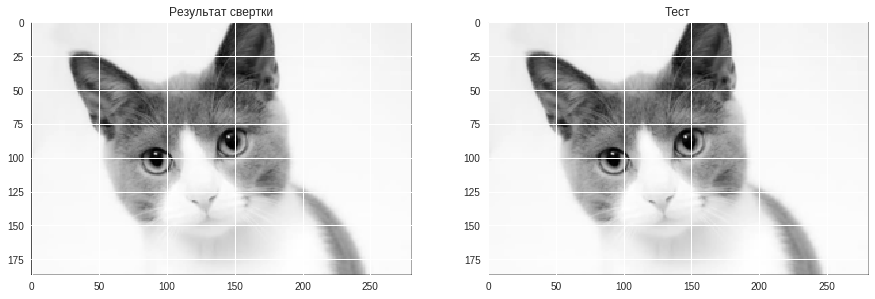

In [0]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2), padding=(2,2)).squeeze_(0)
o_image /= 4 # усредняем
test_conv(o_image, './data/kernel_06.pth')

### Ядро свертки с гаусовым распределением

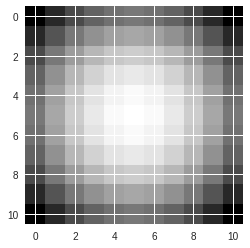

In [0]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([362, 550])
max diff: 8.344650268554688e-07


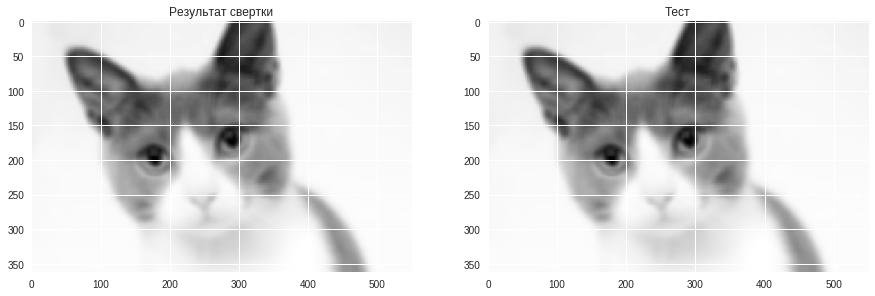

In [0]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0)).squeeze_(0)
test_conv(o_image, './data/kernel_07.pth', False)

# Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - \mu}{ \sqrt{\sigma^2 + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя \ в \ режиме\ тренировки
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \\параметры считаются в процессе тренировки
\gamma, b $ - обучаемые параметры параметры.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй (компонентом векторв)

Нужные функции
```python
import torch
torch.zeros - создать тензор заполненный нулями
torch.ones - создать тензор заполненный единицами
torch.Tensor - создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  - среднее и дисперсия
x.uniform_ - заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) - разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1
x.unsqueeze(dim) - добавить размерность в тензор
x.squeeze - убрать размерность

```

In [14]:
from torch import nn
        
class BatchNorm2d(nn.Module):

    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
         Инициализация BN
         Если задан флаг afine, то должны быть проинициализированны матрицы гамма и b
         для осуществления афинных преобразований в процессе тренировки и теста.
         Обучаемый параметры устанавливаем как тензора соответсвующей размерности и сохраняем
         их
         self.weight
         self.bias
         В данном ДЗ мы не обучаем эти параметры, лишь реализуем саму концепцию.

        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование в процессе обучения.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super().__init__()

        self.epsilon = epsilon
        self.beta = beta
        self.afine = afine

        self.weight = torch.Tensor(1, in_channels, 1, 1).uniform_() # gamma
        self.bias = torch.zeros((1, in_channels, 1, 1))

        self.runing_var = torch.ones((1, in_channels, 1, 1))
        self.runing_mean = torch.zeros((1, in_channels, 1, 1))

    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        используем для расчета праметры gamma и b КАК обучаемые, т.е. учитываем,
        что эти параметры должны быть обучены в процессе тренировки.
        """
        features = [x[:, i, :, :] for i in range(x.shape[1])]
        mean_current = torch.Tensor([feature.mean() for feature in features]).resize_((1, x.shape[1], 1, 1))
        var_current = torch.Tensor([feature.var(unbiased=True) for feature in features]).resize_((1, x.shape[1], 1, 1))

        self.runing_mean = self.beta * self.runing_mean + (1 - self.beta) * mean_current
        self.runing_var = self.beta * self.runing_var + (1 - self.beta) * var_current

        if self.training:
            mean = mean_current
            var = var_current
        else:
            mean = self.runing_mean
            var = self.runing_var

        if self.afine:
            return (x - mean) / torch.sqrt( var + self.epsilon ) * self.weight + self.bias
        else:
            return (x - mean) / torch.sqrt( var + self.epsilon )

### Проверяем работу батч нормадлизации на котэ

torch.Size([372, 560, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AssertionError: Что-то пошло не так, тест не пройден

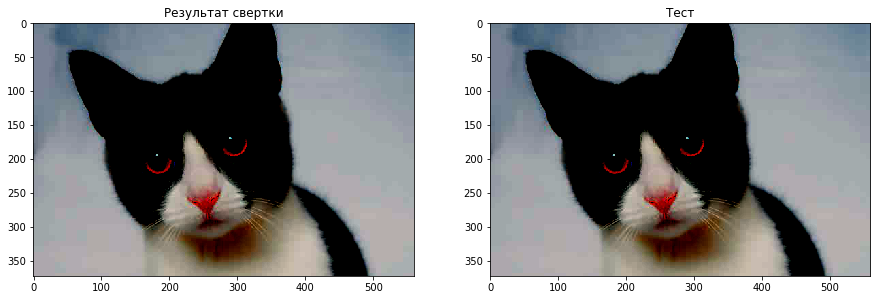

In [15]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
assert bn.training # проверяем, что сеть находится в режиме тренировки
o_image = bn(cat_tensor)
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image, './data/bn_01.pth')

torch.Size([372, 560, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AssertionError: Что-то пошло не так, тест не пройден

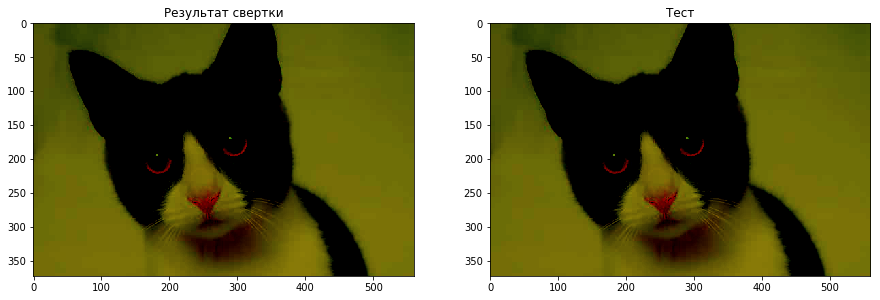

In [16]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
# Поэтому, чтобы получить детерменированный результат устанавливаем seed
torch.manual_seed(999)

bn = BatchNorm2d(3, afine=True)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor)
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image, './data/bn_02.pth')
#print (o_image.size())

### Проверим как реализация работает на большом сете картинок
Цель проверить расчет running_mean and running_var, эти переменные мы расчитываем в режиме тренировки

In [17]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [18]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


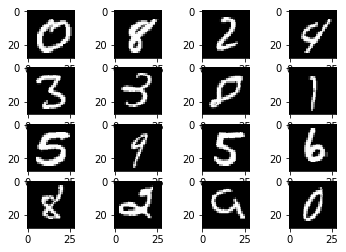

In [19]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются скользящее среднее значение в процессе тренировки

In [20]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    np.random.seed(999)
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ bn.runing_mean ] 
            var_curve +=  [ bn.runing_var ]
    return mean_curve, var_curve

In [21]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

BN beta=09


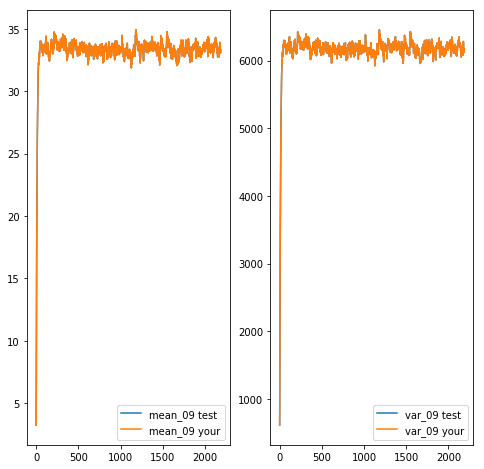

In [22]:
print ("BN beta=09")
test_bn_plots(mean_curve_09, var_curve_09, '09')

BN beta=099


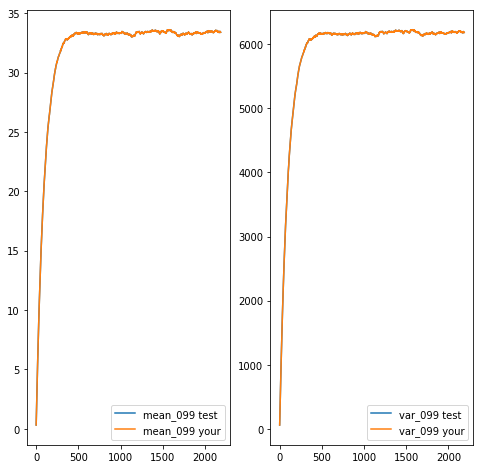

In [23]:
print ("BN beta=099")
test_bn_plots(mean_curve_099, var_curve_099, '099')

BN beta=05


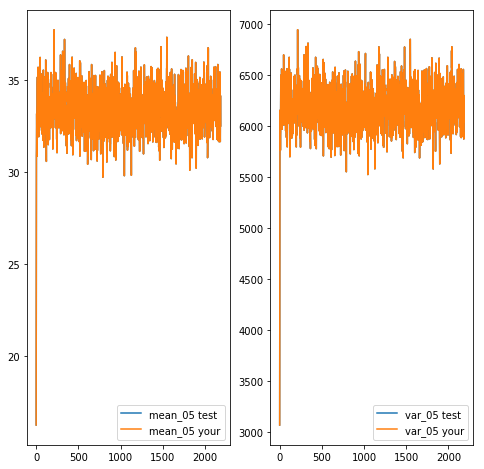

In [24]:
print ("BN beta=05")
test_bn_plots(mean_curve_05, var_curve_05, '05')

Смотрим какие значения средних и дисперсий у нас получились

In [25]:
print ("Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed")
assert int(bn_09.runing_mean[0]) == 33
assert int(bn_099.runing_mean[0]) == 33
assert int(bn_05.runing_mean[0]) == 32
assert int(bn_09.runing_var[0]) == 6136
assert int(bn_099.runing_var[0]) == 6180
assert int(bn_05.runing_var[0]) == 6038
print ('ok')

Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed
ok


Посмотрим как повлияла батч нормализация на изображения

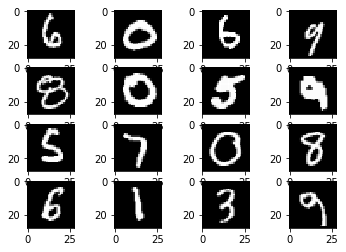

In [30]:
n=4
bn = bn_09
bn.train(False) # эмулируем режим тренировки
np.random.seed(666)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze_(0).unsqueeze_(0)).squeeze(0).squeeze()
    # загрузим сохраненный тестовый тензор 
    t_I = torch.load('./data/bn_minst_%2d.pth'%i)
    # проверим, что нормализованный и тестовый тензор совпадают
    plt.imshow(I, cmap='gray')
    #assert (I == t_I).all(), "Что-то не так нормализованный тензор через running_mean и running_var не совпадают"

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), построить графики для различных параметров для каждого алгоритма, сделать выводы о скорости сходимости


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \ m_{t-1} + (1 - \alpha)\ g - момент \\ 
v_t &= \beta \ v_{t-1} +  (1-\beta)\ g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^{\frac{1}{2}}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$


In [0]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: -
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super().__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas']
            eps = group['eps']
            lr = group['lr']
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                # забираем тензор градиента
                grad = p.grad.data

                # тут храняться значения, которые мы расчитываем в процессе
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # скользящее среднее по квадрату градиентов
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                # запоминаем шаг
                state['step'] += 1

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                exp_avg = beta1 * exp_avg + (1 - beta1) * grad
                exp_avg_sq = beta2 * exp_avg_sq + (1 - beta2) * grad ** 2

                # обновляем веса в p.data,
                exp_avg_hat = exp_avg / ( 1 - beta1 ** state['step'] )
                exp_avg_sq_hat = exp_avg_sq / ( 1 - beta2 ** state['step'] )
                p.data -= lr / torch.sqrt( exp_avg_sq_hat + eps ) * exp_avg_hat

        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta m_{t-1} - (1- \beta) g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha m_{t-1} - \lambda g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [0]:
class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания
        :param eps: -
        """
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super().__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta = group['beta']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue

                d_p = p.grad.data
                state = self.state[p]

                if beta != 0:
                    if len(state) == 0:
                        # тут добавляем момент если он указан
                        state['exp_avg'] = torch.zeros_like(p.data)

                        # запоминаем шаг
                    exp_avg = state['exp_avg']
                    # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                    exp_avg = beta * exp_avg - lr * d_p
                    p.data += exp_avg
                else:
                    p.data  -= lr * d_p

        return loss

Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [0]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [0]:
USE_CUDA=torch.cuda.is_available()
print('CUDA: {}'.format(USE_CUDA))

CUDA: True


## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        # добавляем бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))            
        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        # добавляем бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            
        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))
        # Линейный слой классификатора
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        return x

## Функция обучения модели

In [0]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss.item() )
            loss.backward()
            optimizer.step()  
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [0]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
loss_curve_sgd = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.121456590507079
Do epoch 1 with loss 0.052588637490685694
Do epoch 2 with loss 0.04074797748490507
Do epoch 3 with loss 0.034715487507172356
Do epoch 4 with loss 0.03035673259952922


KeyboardInterrupt: ignored

## SGD с моментом

In [0]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(20, net, optimizer)

## Adam

In [0]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)

# Кривые обучения

In [0]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

### Выводы
Тут нужно написать выводы по сравнению скорости сходимлости алгоритмов SGD, SGD + Momentum, ADAM для различных праметров
1. lr - коэффициент обучения для всех элгоритмов (0.1, 0.01, 0.001, 0.0001) при фиксированных остальных гиперпараметрах 
2. beta - для SGD + momentum (0,9, 0,99, 0,5) для лучшего графика в пункте 1.
3. beta1, beta2 - для ADAM - для различных значений (0,9, 0,99, 0,5) для лучшего графика в пункте 1.

In [0]:
def fit_vary_params(params_list, c_epoch=20):
    # списки loss функций для различных параметров
    loss_curve_sgd_list = []
    loss_curve_sgd_momentum_list = []
    loss_curve_adam_list = []
    
    for params in params_list:
        learning_rate = params['lr']
        beta1 = params['beta1']
        beta2 = params['beta2']
        
        # SGD без момента
        net = Net(batchnorm=True)
        net = net.cuda() if USE_CUDA else net
        optimizer = SGD(net.parameters(), 
                        lr=learning_rate, 
                        beta=0.0)
        loss_curve_sgd_list += [fit_net(c_epoch, net, optimizer)]
        
        # SGD с моментом
        net = Net(batchnorm=True)
        net = net.cuda() if USE_CUDA else net
        optimizer = SGD(net.parameters(), 
                        lr=learning_rate, 
                        beta=beta1)
        loss_curve_sgd_momentum_list += [fit_net(c_epoch, net, optimizer)]
        
        # Adam
        net = Net(batchnorm=True)
        net = net.cuda() if USE_CUDA else net
        optimizer = Adam(net.parameters(), 
                         lr=learning_rate, 
                         betas=(beta1, beta2))
        loss_curve_adam_list += [fit_net(c_epoch, net, optimizer)]
    return loss_curve_sgd_list, loss_curve_sgd_momentum_list, loss_curve_adam_list

In [0]:
params_list = [dict(lr = 0.1, beta1 = 0.9, beta2 = 0.99),
               dict(lr = 0.01, beta1 = 0.9, beta2 = 0.99),
               dict(lr = 0.001, beta1 = 0.9, beta2 = 0.99),
               dict(lr = 0.0001, beta1 = 0.9, beta2 = 0.99)]
loss_list = fit_vary_params(params_list, c_epoch=20)

Do epoch 0 with loss 0.11911524111719289
Do epoch 1 with loss 0.05245495991458564
Do epoch 2 with loss 0.041168840841365066
Do epoch 3 with loss 0.0352703401751588
Do epoch 4 with loss 0.030502626305308908
Do epoch 5 with loss 0.02760410206294463
Do epoch 6 with loss 0.025155540462029707
Do epoch 7 with loss 0.023241667243024778
Do epoch 8 with loss 0.021126237592715678
Do epoch 9 with loss 0.01999671019658031
Do epoch 10 with loss 0.018348828271528766
Do epoch 11 with loss 0.01713939145663911
Do epoch 12 with loss 0.015274433155936306
Do epoch 13 with loss 0.015647307985386022
Do epoch 14 with loss 0.014567795423786554
Do epoch 15 with loss 0.013130521475859957
Do epoch 16 with loss 0.01238587312655848
Do epoch 17 with loss 0.011559058755813367
Do epoch 18 with loss 0.010941259225700127
Do epoch 19 with loss 0.009782862086845524
Do epoch 0 with loss 0.12419299166913604
Do epoch 1 with loss 0.054806000257961056
Do epoch 2 with loss 0.04287350020031979
Do epoch 3 with loss 0.03532602743

**При lr > 0.001 Adam расходится. В остальных случаях Adam сходится значительно быстрее. SGD с моментом показываетс себя незначительно лучше, чем SGD без момента. Считаю оптимальным lr = 0.001**

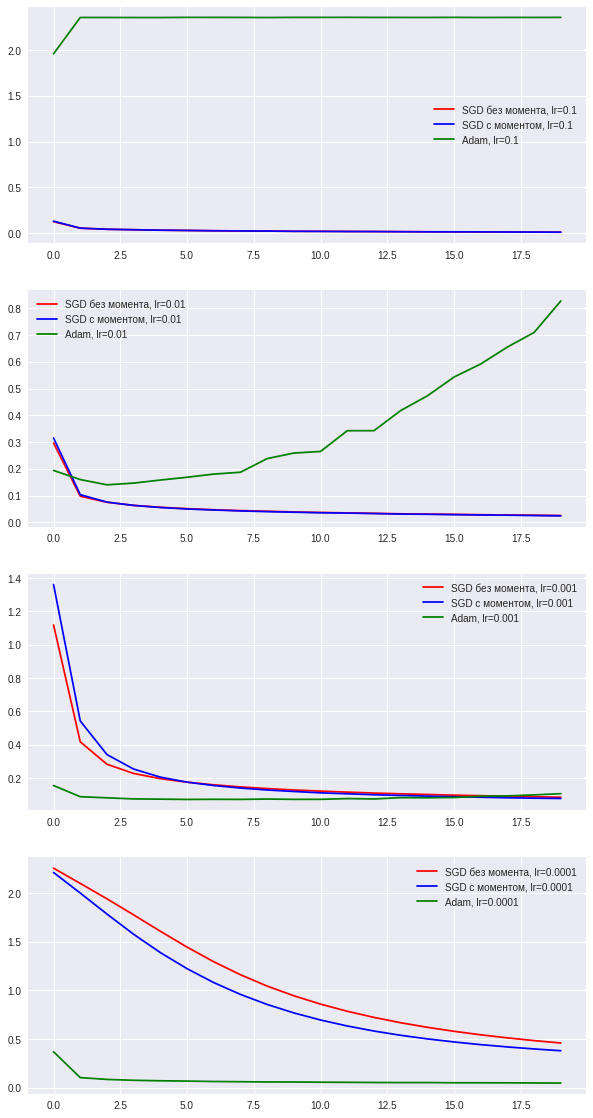

In [0]:
plt.figure(figsize=(10,20))
for i in range(len(loss_list[0])):
    ax = plt.subplot(4,1,i + 1)
    ax.plot(loss_list[0][i], color='red',label='SGD без момента, lr={}'.format(params_list[i]['lr']))
    ax.legend()

    ax.plot(loss_list[1][i], color='blue', label='SGD с моментом, lr={}'.format(params_list[i]['lr']))
    ax.legend()
    
    ax.plot(loss_list[2][i], color='green',label='Adam, lr={}'.format(params_list[i]['lr']))
    ax.legend()

**Cравнение SGD с моментом для различных lr**

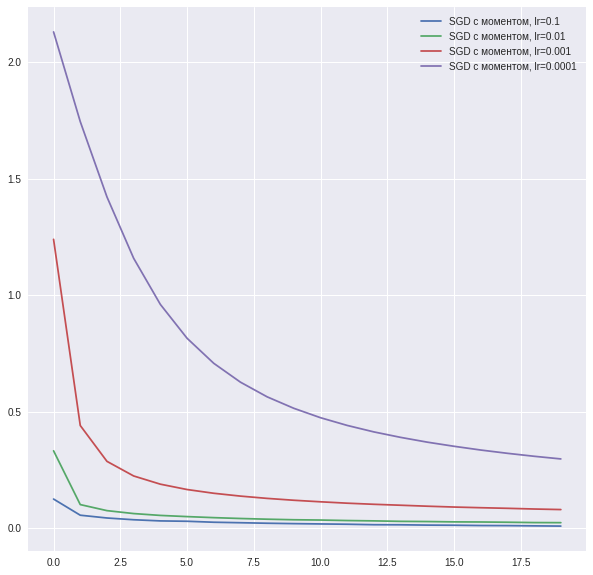

In [59]:
plt.figure(figsize=(10,10))
plt.plot(loss_list[1][0],label='SGD c моментом, lr={}'.format(params_list[0]['lr']))
plt.plot(loss_list[1][1],label='SGD c моментом, lr={}'.format(params_list[1]['lr']))
plt.plot(loss_list[1][2],label='SGD c моментом, lr={}'.format(params_list[2]['lr']))
plt.plot(loss_list[1][3],label='SGD c моментом, lr={}'.format(params_list[3]['lr']))
plt.legend()


In [63]:
loss_momentum_different_beta_list = []
c_epochs = 20
beta_list = [0.9, 0.99, 0.5]
for beta in beta_list:
  learning_rate = 0.001
  net = Net(batchnorm=True)
  net = net.cuda() if USE_CUDA else net
  optimizer = SGD(net.parameters(), lr=learning_rate, beta=beta)
  loss_momentum_different_beta_list += [fit_net(c_epochs, net, optimizer)]

Do epoch 0 with loss 1.2774836703501284
Do epoch 1 with loss 0.4449632745193574
Do epoch 2 with loss 0.28163467131633435
Do epoch 3 with loss 0.21783635919980934
Do epoch 4 with loss 0.18291965614498398
Do epoch 5 with loss 0.1606259634254128
Do epoch 6 with loss 0.1446981182058734
Do epoch 7 with loss 0.13245522955481082
Do epoch 8 with loss 0.12332594508639906
Do epoch 9 with loss 0.11556183566711077
Do epoch 10 with loss 0.10943938230318079
Do epoch 11 with loss 0.1036690112627501
Do epoch 12 with loss 0.09926203963830965
Do epoch 13 with loss 0.09497934668424961
Do epoch 14 with loss 0.09160142826792798
Do epoch 15 with loss 0.08815488148911609
Do epoch 16 with loss 0.08545782271079348
Do epoch 17 with loss 0.08269742040954119
Do epoch 18 with loss 0.08033542324472466
Do epoch 19 with loss 0.07790318877867601
Do epoch 0 with loss 1.2620002787354117
Do epoch 1 with loss 0.4249934118648179
Do epoch 2 with loss 0.2750744487277765
Do epoch 3 with loss 0.21726719482499932
Do epoch 4 wit

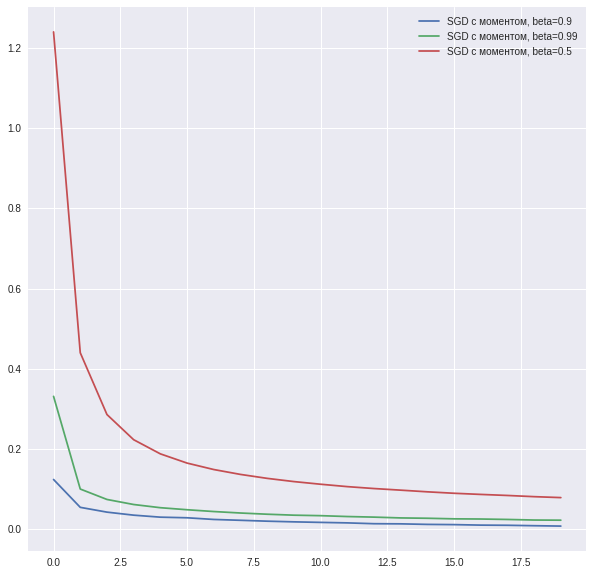

In [65]:
plt.figure(figsize=(10,10))
plt.plot(loss_list[1][0],label='SGD c моментом, beta={}'.format(beta_list[0]))
plt.plot(loss_list[1][1],label='SGD c моментом, beta={}'.format(beta_list[1]))
plt.plot(loss_list[1][2],label='SGD c моментом, beta={}'.format(beta_list[2]))
plt.legend()

Оптимальный beta для SGD с моментом: 0.9

In [66]:
loss_adam_different_beta_list = []
c_epochs = 20
learning_rate = 0.001
beta_list = [0.9, 0.99, 0.5]
for beta1 in beta_list:
  for beta2 in beta_list:
    net = Net(batchnorm=True)
    net = net.cuda() if USE_CUDA else net
    optimizer = Adam(net.parameters(), lr=learning_rate, betas=(beta1, beta2))
    loss_adam_different_beta_list += [fit_net(c_epochs, net, optimizer)]

Do epoch 0 with loss 0.3273961261846551
Do epoch 1 with loss 0.09882264857184249
Do epoch 2 with loss 0.08383911448796154
Do epoch 3 with loss 0.07599934400027344
Do epoch 4 with loss 0.07017293726411321
Do epoch 5 with loss 0.06792833181511174
Do epoch 6 with loss 0.06477789798173177
Do epoch 7 with loss 0.0622829163406993
Do epoch 8 with loss 0.06214099819931637
Do epoch 9 with loss 0.060920576118256436
Do epoch 10 with loss 0.058048306832751785
Do epoch 11 with loss 0.05512149736223888
Do epoch 12 with loss 0.055096955946934076
Do epoch 13 with loss 0.05481192549996361
Do epoch 14 with loss 0.0532031811477389
Do epoch 15 with loss 0.05086924030075457
Do epoch 16 with loss 0.05061989720139157
Do epoch 17 with loss 0.05054249347046624
Do epoch 18 with loss 0.04915431889977475
Do epoch 19 with loss 0.04959629374549004
Do epoch 0 with loss 0.22203452709532515
Do epoch 1 with loss 0.07636035450746548
Do epoch 2 with loss 0.06514547674635202
Do epoch 3 with loss 0.05895850159122239
Do epo

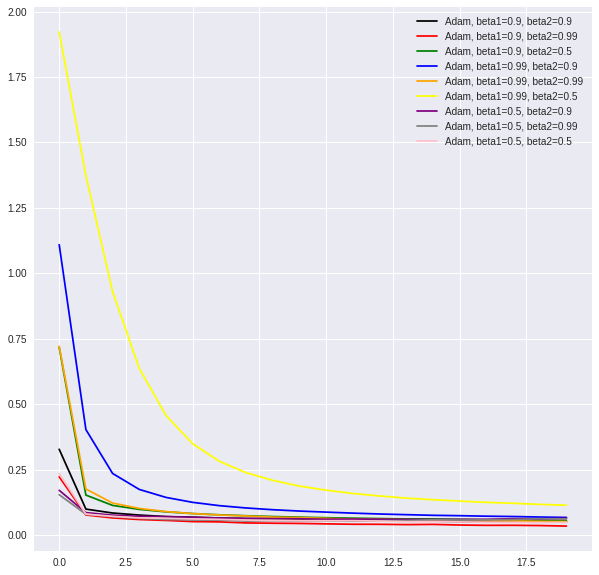

In [69]:
plt.figure(figsize=(10,10))
colors = ['black', 'red', 'green', 'blue', 'orange', 'yellow', 'purple', 'grey', 'pink']

for i1 in range(len(beta_list)):
  for i2 in range(len(beta_list)):
    plt.plot(loss_adam_different_beta_list[i1 * 3 + i2],
             color=colors[i1 * 3 + i2],
             label='Adam, beta1={}, beta2={}'.format(beta_list[i1],
                                                     beta_list[i2]))
plt.legend()


Лучшие результаты при beta1 = 0.5 и beta2 = 0.99